# Dead ReLU Problem成因分析

<Axes: >

<Axes: >

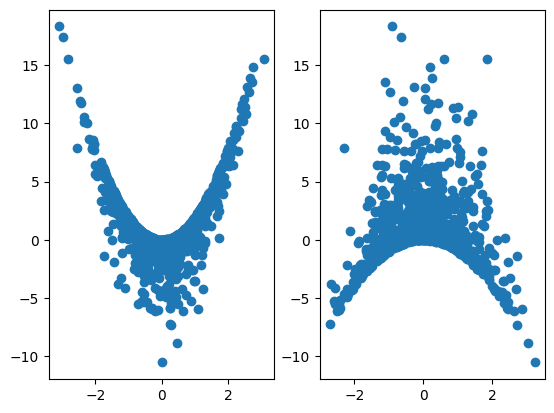

In [3]:
# 设置随机数种子
torch.manual_seed(420)

# 创建最高项为2的多项式回归数据集
features,labels = tensorGenReg(w=[2,-1],bias=False,deg=2)

# 绘制图像查看数据分布
plt.subplot(121)
plt.scatter(features[:,0],labels)
plt.subplot(122)
plt.scatter(features[:,1],labels)

In [4]:
# 进行数据集切分与加载
train_loader,test_loader = split_loader(features,labels)

In [13]:
# 创建随机数种子
torch.manual_seed(420)

# 实例化模型
relu_model3 = ReLu_class3(bias=False)

# 核心参数
num_epochs = 20
lr = 0.03

In [5]:
train_l,test_l = model_train_test(relu_model3
                                 ,train_loader
                                 ,test_loader
                                 ,num_epochs=num_epochs
                                 ,criterion=nn.MSELoss()
                                 ,optimizer=optim.SGD
                                 ,lr=0.03
                                 ,cla=False
                                 ,eva=mse_cal)

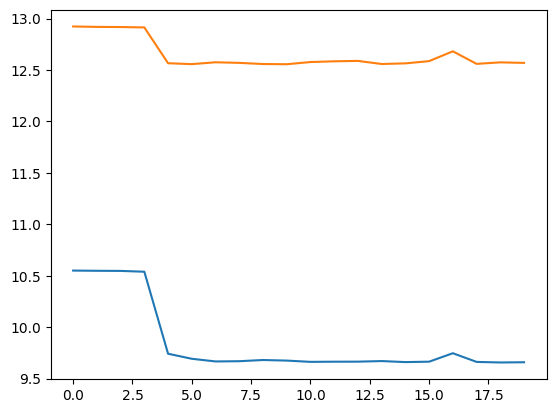

In [7]:
plt.plot(list(range(num_epochs)),train_l)
plt.plot(list(range(num_epochs)),test_l)

## Dead ReLu Problem成因分析 

神经元活性失效问题和ReLU激活函数本身特性有关。首先，我们观察ReLU激活函数函数图像与导函数图像.

In [1]:
# 绘制ReLu函数图像和导函数图像
X = torch.arange(-5,5,0.1)
X.requires_grad = True
relu_y = torch.relu(X)

In [2]:
# 反向传播
relu_y.sum().backward()

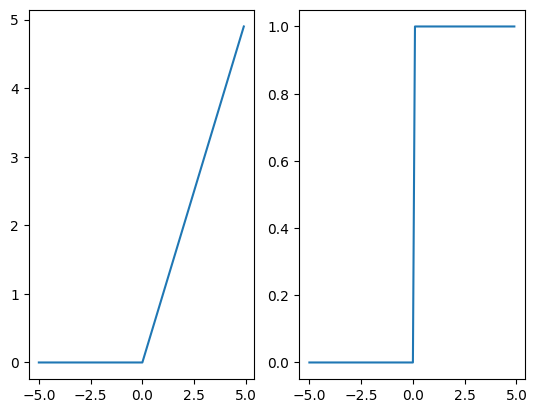

In [3]:
# ReLu函数图像
plt.subplot(121)
plt.plot(X.detach(),relu_y.detach())
# ReLu导数图像
plt.subplot(122)
plt.plot(X.detach(),X.grad.detach())

我们进一步通过举例说明，现在有模型基本结构如下

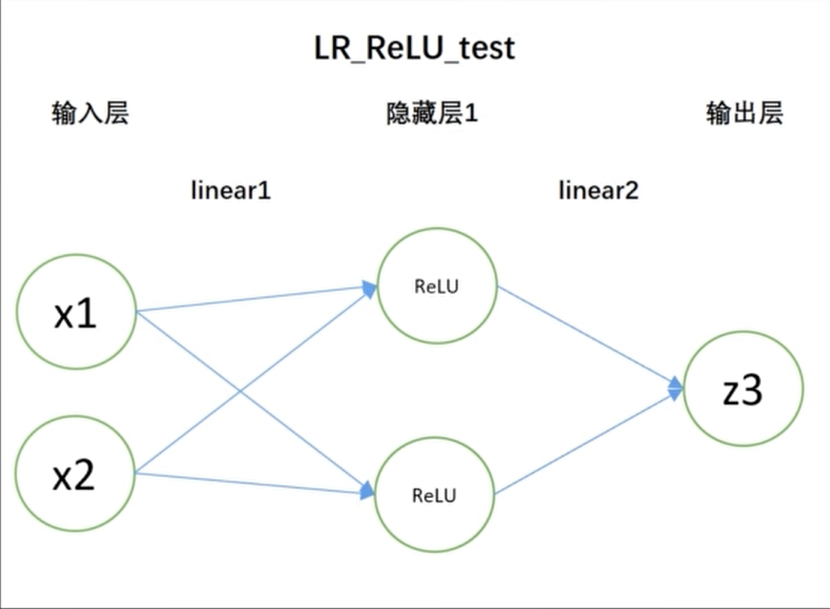

设w1为第一层传播的权重，w2为第二层传播的权重，的权重，f为输入的特征张量，并且只有一条数据并且w1的第一列对应连接隐藏层第一个神经元的权重w1的第二列对应连接隐藏层第二个神经元

In [33]:
w1 = torch.tensor([[0.,0],[-1,-2]],requires_grad = True)
w1

tensor([[ 0.,  0.],
        [-1., -2.]], requires_grad=True)

In [46]:
w2 = torch.tensor([1.,-1]).reshape(-1,1)
w2.requires_grad = True
w2

tensor([[ 1.],
        [-1.]], requires_grad=True)

In [47]:
f = torch.tensor([[1,2.]])
f

tensor([[1., 2.]])

第一次向前传播过程如下

In [48]:
# 线性变换
f2 =torch.mm(f,w1)
f2

tensor([[-2., -4.]], grad_fn=<MmBackward0>)

In [49]:
# 激活函数处理
f3 = torch.relu(f2)

In [50]:
# 输出结果
out = torch.mm(f3,w2)
out

tensor([[0.]], grad_fn=<MmBackward0>)

l为的真实标签，则损失函数和反向传播过程如下

In [51]:
l = torch.tensor([[3.]])
l

tensor([[3.]])

In [52]:
loss = F.mse_loss(out,l)
loss

tensor(9., grad_fn=<MseLossBackward0>)

In [53]:
loss.backward()

而此时w1、w2的梯度如下:

In [56]:
w1.grad
w2.grad

tensor([[0.],
        [0.]])

我们发现，当某条数据在模型中的输出结果为0时，反向传播后各层参数的梯度也全为0，此时参数将无法通过迭代更新。而进一步的，如果在某种参数情况下，整个训练数据集输入模型之后输出结果都是0，则在小批量梯度下降的情况下，每次再挑洗出一些教据继续进行迭代，仍然无法改变输出结果是0的情况，此时参数无法得到更新、进而下次输入的小批数据结果还是零、从而梯度为0、从而参数无法更新.至此陷入死循环，模型失效、激活函数失去活性，也就出现了Dead ReLU Problem。

# nn.Sequential快速建模方法及nn.init模型参数自定义方法

## nn.Sequential快速建模方法介绍

首先补充关于使用nn.Sequential进行快速建模的方法介绍。在此前的建模环节，我们都是通过完整的创建模型类、通过定义init方法和forward方法来确定模型的基本结构、传播方式和激活函数。除了这种模型定义方法外，Plorch还支持使用nSequential来快速，在借mn.Sequentia进行模型构建过程中，我们只需要将每一层神经元连接方法和激活函数作为参数输入nn.Sequential即可，具体流程如下:

In [22]:
# 设置随机数种子
torch.manual_seed(25)

# 构建上述LR_ReLU_test模型
relu_test = nn.Sequential(nn.Linear(2,2,bias = False),nn.ReLU(),nn.Linear(2,1,bias=False))

在上述模型定义过程中，relu_test相当于已经实例化之后的模型

In [3]:
list(relu_test.parameters())

[Parameter containing:
 tensor([[ 0.3561, -0.4343],
         [-0.6182,  0.5823]], requires_grad=True),
 Parameter containing:
 tensor([[-0.1658, -0.2843]], requires_grad=True)]

而此时的实例化，是nn.Sequential类的实例化也就是说，通过nn.Sequential创建的模型本质上都是nn.Sequential的一个实例

In [4]:
isinstance(relu_test,nn.Sequential)

True

In [15]:
# 而此前创建的模型都是我们所创建的类的实例
isinstance(relu_model3,ReLu_class3)

True

而上述 nSequential 所创建的模型结构，就相当于是两层全连接神经网络，并目隐藏层使用RelU进行处理，其中需要注意的是，mn.ReLU0单独使用时就相当于ReLU函数，而放在nn.Sequential中就等价于对某一层的输出结果进行ReLU处理

In [16]:
r1 = nn.ReLU()

In [17]:
t = torch.tensor([1.,-1])
t

tensor([ 1., -1.])

In [18]:
r1(t)

tensor([1., 0.])

In [19]:
torch.relu(t)

tensor([1., 0.])

当然，通过nn.Sequential定义的模型也可以执行向前传播过程

In [20]:
f = torch.tensor([[1,2.]],requires_grad = True)
f

tensor([[1., 2.]], requires_grad=True)

In [23]:
relu_test.forward(f)

tensor([[-0.1553]], grad_fn=<MmBackward0>)

我们可以手动验证

In [24]:
w1 = list(relu_test.parameters())[0].t()   # 第一层传播参数
w1

tensor([[ 0.3561, -0.6182],
        [-0.4343,  0.5823]], grad_fn=<TBackward0>)

In [25]:
w2 = list(relu_test.parameters())[1].t()   # 第二层传播参数
w2

tensor([[-0.1658],
        [-0.2843]], grad_fn=<TBackward0>)

In [26]:
torch.mm(torch.relu(torch.mm(f,w1)),w2)

tensor([[-0.1553]], grad_fn=<MmBackward0>)

当然，如果进一步将rele的参数手动设置为此前设置的w1和w2，就可以复现ReLU激活函数的活性失效例子。那如何才能在手动修改模型参数值呢?我们将在下面一小节进行补充。

总而言之，我们不难发现，利用nn.Sequentia进行模型创建在模型结构相对简单时可以大幅减少代码量，并且模型效果和先通过定义类、再进行实例化的模型效果相同，但该方法在定义高度复杂的模型、或者定义更加灵活的模型时就显得力不从心了。因此，对于新手，推荐先掌握利用类定义模型的方法，再掌握利用nn.Sequential定义模型的方法。

## 模型参数自定义方法

接下来，继续补充关于手动设置模型初始参数及模型参数共享的方法。首先，对于模型参数来说，parameters返回结果是个生成器(generator)通过list转化尼会生成一个由可微张量构成的list。

### 通过修改可微张量方法修改参数

In [28]:
relu_test.parameters()

<generator object Module.parameters at 0x0000023313E7AF20>

In [29]:
list(relu_test.parameters())

[Parameter containing:
 tensor([[ 0.3561, -0.4343],
         [-0.6182,  0.5823]], requires_grad=True),
 Parameter containing:
 tensor([[-0.1658, -0.2843]], requires_grad=True)]

In [30]:
list(relu_test.parameters())[0]

Parameter containing:
tensor([[ 0.3561, -0.4343],
        [-0.6182,  0.5823]], requires_grad=True)

因此，我们可以通过修改可微张量数值的方法对其进行修改，在Lesson 12中，我们介绍了三种修改可微张量数值的方法，这里我们直接使用.data的方法对其进行修改:

In [32]:
# 修改目标
w1 = torch.tensor([[0.,0],[-1,-2]])
w2 = torch.tensor([1.,-1]).reshape(-1,1)
w1
w2

tensor([[ 0.,  0.],
        [-1., -2.]])

tensor([[ 1.],
        [-1.]])

In [33]:
list(relu_test.parameters())[0].data = w1.t()

In [34]:
list(relu_test.parameters())[1].data = w2.t()

In [36]:
# 查看修改结果
list(relu_test.parameters())

[Parameter containing:
 tensor([[ 0., -1.],
         [ 0., -2.]], requires_grad=True),
 Parameter containing:
 tensor([[ 1., -1.]], requires_grad=True)]

然后即可执行向前传播

In [37]:
f = torch.tensor([1,2.])
f

tensor([1., 2.])

In [38]:
# 模型输出结果
out = relu_test.forward(f)
out

tensor([0.], grad_fn=<SqueezeBackward4>)

In [39]:
# 真实标签
l = torch.tensor([3.])
l

tensor([3.])

计算损失函数

In [40]:
loss = F.mse_loss(out,l)
loss

tensor(9., grad_fn=<MseLossBackward0>)

进行反向传播

In [42]:
loss.backward()

查看模型参数梯度

In [43]:
list(relu_test.parameters())[0].grad

tensor([[0., 0.],
        [0., 0.]])

In [44]:
list(relu_test.parameters())[1].grad

tensor([[0., 0.]])

### 使用init方法创建满足某种分布的参数

除了通过手动方法修改参数值以外，我们还可以使用nn.init方法来对模型参数进行修改。

In [45]:
# 设置随机数种子
torch.manual_seed(25)

# 构建上述LR_ReLU_test模型
relu_test = nn.Sequential(nn.Linear(2,2,bias = False),nn.ReLU(),nn.Linear(2,1,bias=False))

In [46]:
list(relu_test.parameters())

[Parameter containing:
 tensor([[ 0.3561, -0.4343],
         [-0.6182,  0.5823]], requires_grad=True),
 Parameter containing:
 tensor([[-0.1658, -0.2843]], requires_grad=True)]

<li> nn.init.uniform_方法，新生成的参数服从均匀分布

In [53]:
# 参数要为张量
# 设置参数值为均分布在0，1区间内的随机数
nn.init.uniform_(list(relu_test.parameters())[0],0,1)

Parameter containing:
tensor([[0.0284, 0.8488],
        [0.3947, 0.5181]], requires_grad=True)

In [49]:
nn.init.uniform_(relu_test.parameters(),0,1)

AttributeError: 'generator' object has no attribute 'uniform_'

<li> nn.init.normal_方法，新生成的参数服从正态分布

In [56]:
# 服从均值为0,标准差为1的正态分布
nn.init.normal_(list(relu_test.parameters())[0],0,1)

Parameter containing:
tensor([[ 1.6520, -0.0873],
        [-1.5217,  0.6919]], requires_grad=True)

<li> nn.init.constant_方法，新生成的参数值为某一常数

In [57]:
# 参数全为1
nn.init.constant_(list(relu_test.parameters())[0],1)

Parameter containing:
tensor([[1., 1.],
        [1., 1.]], requires_grad=True)

当然，上述过程并不复杂，并且相同的修改目标，使用手动方式也能实现。对于nninit方法来说，最核心的使用场景是能够创建服从特殊分布、具备一定特性的、能够辅助模型迭代收敛的初始参数。相关方法我们将在下一小节详细介绍。